In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import re
import pymorphy2

from wordcloud import WordCloud
from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anatoly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Обработка данных

In [20]:
compliments_df = pd.read_csv("FreeCompliments-filtered.csv", sep="\t", header=None)
compliments_df['status'] = "flattery"
compliments_df = compliments_df[[5, "status"]]
compliments_df


,5,status
0,Stay away from people who can't put themselves...,flattery
1,"If the answer is no, then you accept the hand ...",flattery
2,I know you have it in you to face your current...,flattery
3,You serve our kind with great honor.,flattery
4,That's your foot hold to climb the fucking mou...,flattery
...,...,...
19267,Love your hair girl!,flattery
19268,Your hair and makeup looks so good!,flattery
19269,"I understand self-hatred, especially the showi...",flattery
19270,"You have a very honest, natural face with real...",flattery


In [21]:

insults_df = pd.read_csv("RoastMe-filtered.csv", sep="\t", header=None)
insults_df['status'] = "insult"
insults_df = insults_df[[5, "status"]]
insults_df

,5,status
0,It looks like someone burnt the left side of y...,insult
1,you look like the kind of guy who would make a...,insult
2,You need to switch adjectives between your bod...,insult
3,You look like you got paid to hold a dudes loa...,insult
4,Your face has more topography than the wall.,insult
...,...,...
68223,I'm going to assume you're female only because...,insult
68224,I'm not sure why you thought the eyeliner woul...,insult
68225,Can I use your forehead to flag down airplanes...,insult
68226,You could shine the Bat Signal at your forehea...,insult


In [22]:
insult_flattery_df = pd.read_csv("insults.csv", header=None)
insult_flattery_df['status'] = "insult_as_flattery"
instult_flattery_df = insult_flattery_df[[0, "status"]]
insult_flattery_df[5] = insult_flattery_df[0]

In [23]:
data = pd.DataFrame()
data[["stmt", "status"]] = pd.concat([compliments_df, insults_df], ignore_index=True)

data

,stmt,status
0,Stay away from people who can't put themselves...,flattery
1,"If the answer is no, then you accept the hand ...",flattery
2,I know you have it in you to face your current...,flattery
3,You serve our kind with great honor.,flattery
4,That's your foot hold to climb the fucking mou...,flattery
...,...,...
87771,"You're so intelligent, it's almost like you're...",insult_as_flattery
87772,"You have such great potential, it's almost lik...",insult_as_flattery
87773,"You're so confident, it's almost like you're o...",insult_as_flattery
87774,"You have such a great imagination, it's almost...",insult_as_flattery


In [25]:
def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

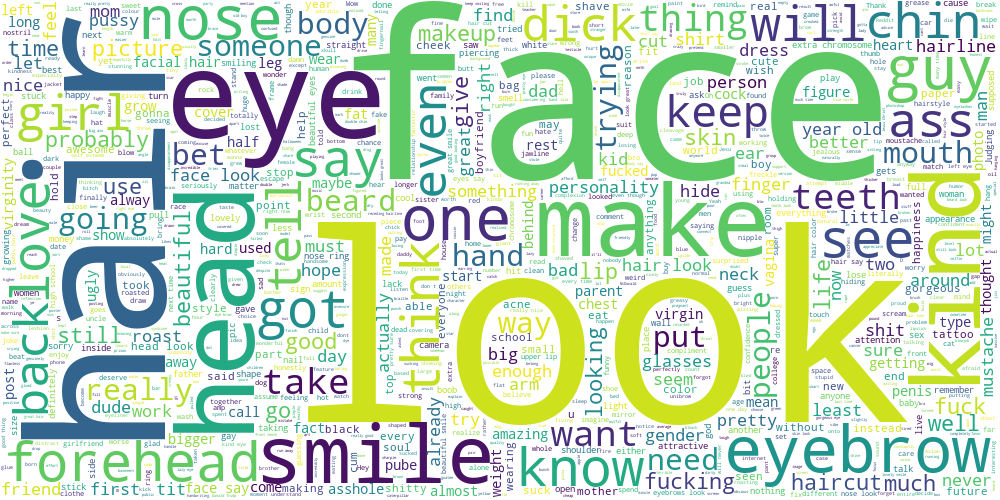

In [26]:
draw_wordcloud(data.stmt)

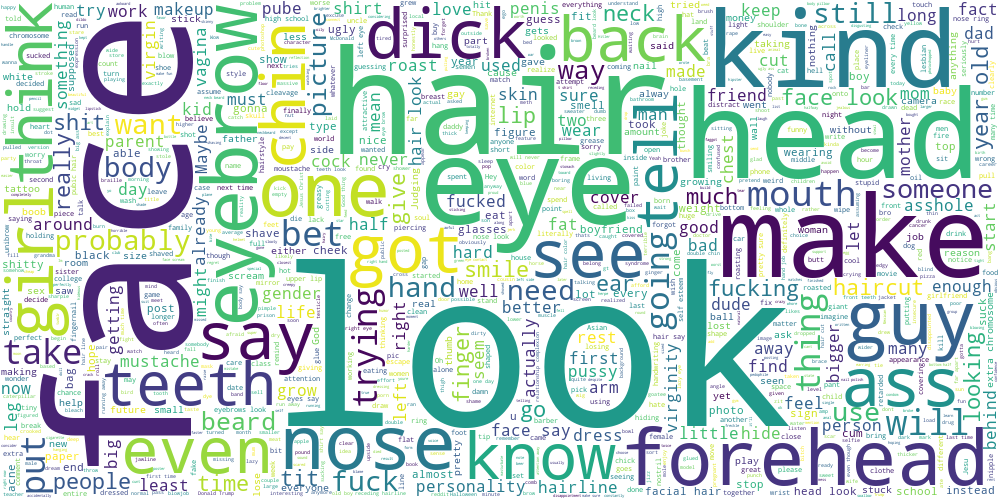

In [27]:
draw_wordcloud(data[data.status == "insult"].stmt)

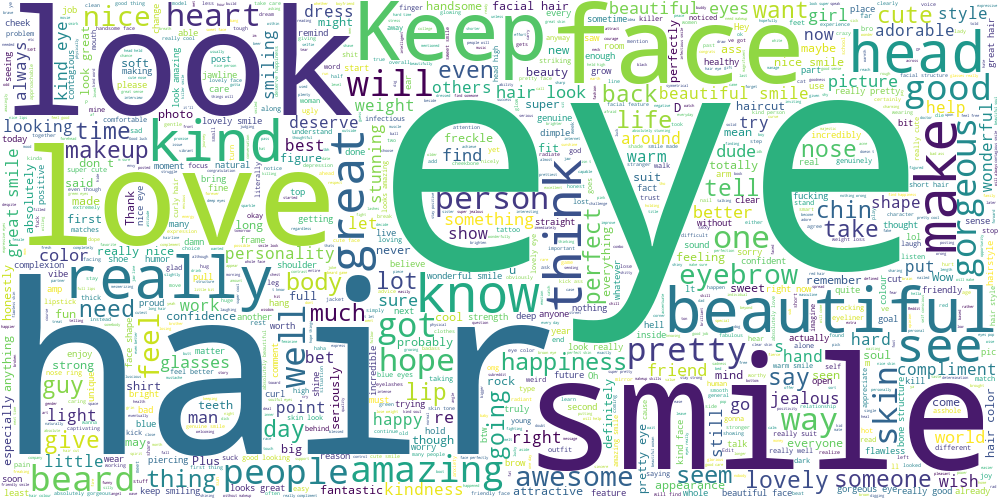

In [28]:
draw_wordcloud(data[data.status == "flattery"].stmt)

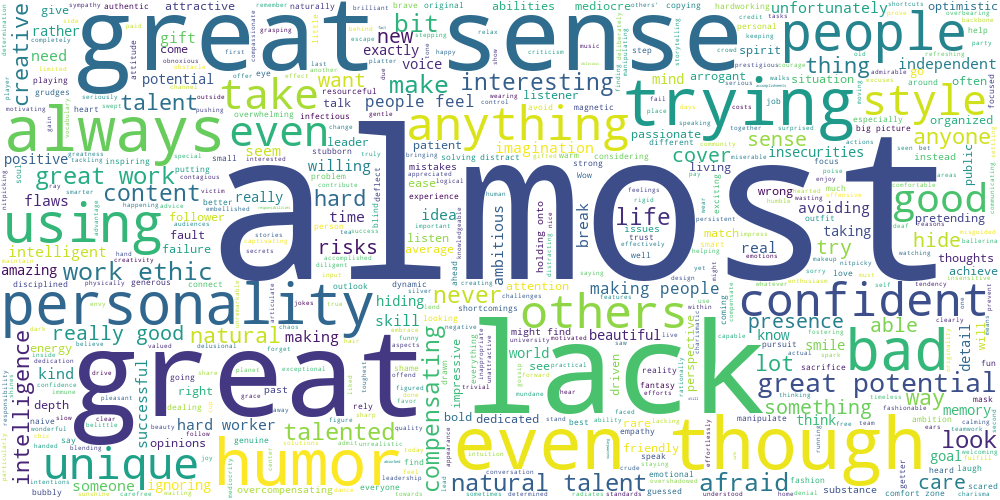

In [29]:
draw_wordcloud(data[data.status == "insult_as_flattery"].stmt)

In [30]:
TOKEN_RE = re.compile(r'[A-z]+')
lemmatizer = pymorphy2.MorphAnalyzer()
stopwords = stopwords.words("english")

def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_stopwords(tokens):
    return list(filter(lambda token: token not in stopwords, tokens))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(txt):
    tokens = tokenize_text(txt)
    tokens  = lemmatizing(tokens)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)



Построение модели определения оскорблений

In [31]:
df_train, df_test = train_test_split(data, 
                                     random_state=311, 
                                     test_size=0.33, 
                                     stratify=data['status']
                                    )

train_corpus = df_train['stmt'].values
test_corpus = df_test['stmt'].values

y_train = df_train['status']
y_test = df_test['status']
df_test.stmt.apply(text_cleaning)
print(df_test)

                                                    stmt    status
9753                And you have a very welcoming smile.  flattery
37448  Got into body building competitions because yo...    insult
15795  Maybe we can get an eye transplant so you can ...  flattery
47449  Are you wearing all that grey to try and make ...    insult
23564         Your eyes are a really nice shade of blue.    insult
...                                                  ...       ...
81183  You're nothing but skin and sharp bones Only l...    insult
69975  It looks like somebody actually swiped left on...    insult
69194  Is that a man bun or did your boyfriend just r...    insult
59426  Ugly tattoos but at least they distract from y...    insult
28466  Your clothes says "Gypsy" but your face says "...    insult

[28967 rows x 2 columns]


In [39]:

train_data, test_data, train_labels, test_labels = train_test_split(data['stmt'], data['status'], test_size=0.33, random_state=42)


vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)


ValueError: not enough values to unpack (expected 4, got 2)

In [38]:
model = LogisticRegression()
model.fit(train_vectors, train_labels)

predictions = model.predict(test_vectors)


accuracy = accuracy_score(test_labels, predictions)
accuracy

test_labels

19776      insult
491      flattery
66164      insult
49533      insult
19548      insult
           ...   
28872      insult
26910      insult
60838      insult
45745      insult
28430      insult
Name: status, Length: 28967, dtype: object

In [ ]:
only_flattery_df = predictions

second_model = LogisticRegression()
second_model.fit()

In [ ]:
message = "You have a special talent for making people feel like they're not good enough, even when they're trying their best"
clean_message = text_cleaning(message)
X_example = vectorizer.transform([clean_message])
insult_porbability = model.predict_proba(X_example)[0,1]
print(f'Probability of insult: {insult_porbability:.2f}')

special talent making people feel like good enough even trying best
Probability of insult: 0.70


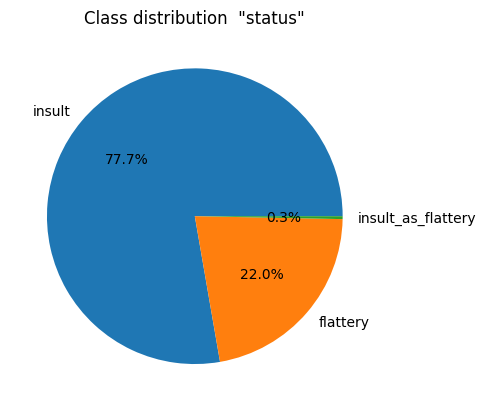

In [24]:
data['status'].value_counts().plot(kind='pie', title='Class distribution  "status"', autopct='%1.1f%%')
plt.axis('off')
plt.show()